In [1]:
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt


tsv_301 = '00-data/P29702_301.transcript_expression.processed.tsv'
tsv_303 = '00-data/P29702_303.transcript_expression.processed.tsv'
tsv_401 = '00-data/P29702_401.transcript_expression.processed.tsv'
gencode_filtered = '00-data/transcript_gene.tsv'

# Created from gencode using: awk '{if($3=="transcript"){print $14,$20}}' genes.gtf > transcript_gene.tsv
# eg. line: '"ENST00000473358"; "MIR1302-2HG";'
transcript_gene_map = {}
with open(gencode_filtered) as f:
    while True:
        line = f.readline()
        if not line:
            break
        transcript, gene, _ = line.strip().split(";")
        transcript = re.sub('"', '', transcript)
        gene = re.sub('"', '', gene)
        transcript_gene_map[transcript] = gene

adata_301 = sc.read_csv(tsv_301, delimiter='\t', first_column_names=True)
adata_303 = sc.read_csv(tsv_303, delimiter='\t', first_column_names=True)
adata_401 = sc.read_csv(tsv_401, delimiter='\t', first_column_names=True)

# transpose
adata_301 = adata_301.T
adata_303 = adata_303.T
adata_401 = adata_401.T


In [2]:
# normalize anc cluster each dataset
for adata in [adata_301, adata_303, adata_401]:
    sc.pp.normalize_total(adata, inplace=True)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)
    sc.pp.pca(adata)
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)
    sc.tl.leiden(
        adata, key_added="clusters", flavor="igraph", directed=False, resolution=0.4
    )
    print(adata.var["highly_variable"])

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


ENST00000000233    False
ENST00000000412    False
ENST00000001008    False
ENST00000002125    False
ENST00000002165    False
                   ...  
ENST00000673531    False
ENST00000673551    False
ENST00000673559    False
ENST00000673591    False
ENST00000673600    False
Name: highly_variable, Length: 47337, dtype: bool
ENST00000000233    False
ENST00000000412    False
ENST00000000442    False
ENST00000001008    False
ENST00000002125    False
                   ...  
ENST00000673531    False
ENST00000673562    False
ENST00000673571    False
ENST00000673580    False
ENST00000673603    False
Name: highly_variable, Length: 45659, dtype: bool
ENST00000000233    False
ENST00000000412    False
ENST00000001008    False
ENST00000002125    False
ENST00000002165    False
                   ...  
ENST00000673510    False
ENST00000673518    False
ENST00000673531    False
ENST00000673559    False
ENST00000673591    False
Name: highly_variable, Length: 47708, dtype: bool


/var/folders/t2/7vd51j0n3x913rpzs034z0sx88zdmm/T/ipykernel_16052/3421918955.py:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a = sns.lineplot(x=list(tpr_freq.keys()), y=list(tpr_freq.values()), palette="tab10", label=tpr_names[i])
/var/folders/t2/7vd51j0n3x913rpzs034z0sx88zdmm/T/ipykernel_16052/3421918955.py:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a = sns.lineplot(x=list(tpr_freq.keys()), y=list(tpr_freq.values()), palette="tab10", label=tpr_names[i])
/var/folders/t2/7vd51j0n3x913rpzs034z0sx88zdmm/T/ipykernel_16052/3421918955.py:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a = sns.lineplot(x=list(tpr_freq.keys()), y=list(tpr_freq.values()), palette="tab10", label=tpr_names[i])


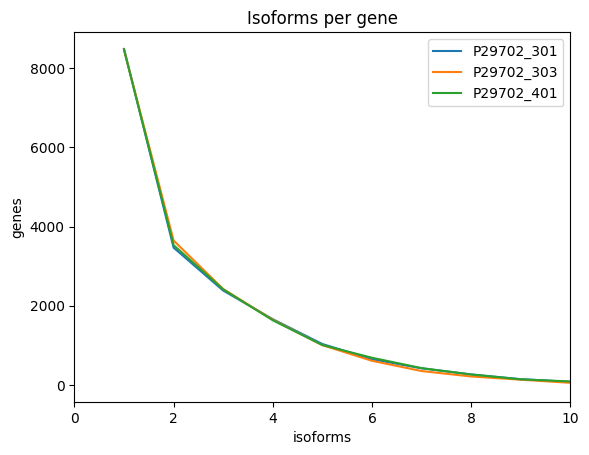

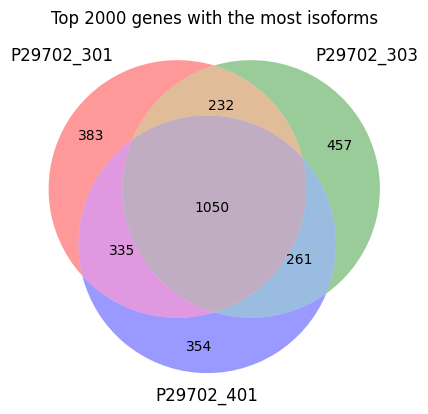

In [3]:
import seaborn as sns
# find the number of transcripts per gene in each dataset
transcripts_per_gene = []
tpr_names = ["P29702_301", "P29702_303", "P29702_401"]
for adata in [adata_301, adata_303, adata_401]:
    tpr = {}
    for transcript in adata.var_names:
        gene = transcript_gene_map[transcript]
        tpr[gene] = tpr.get(gene, 0) + 1
    transcripts_per_gene.append(tpr)

tpr_freqs = []
# create frequency tables for each dataset
for tpr in transcripts_per_gene:
    tpr_freq = {}
    for gene, count in tpr.items():
        tpr_freq[count] = tpr_freq.get(count, 0) + 1
    tpr_freqs.append(tpr_freq)

# plot frequency tables
for i,tpr_freq in enumerate(tpr_freqs):
    a = sns.lineplot(x=list(tpr_freq.keys()), y=list(tpr_freq.values()), palette="tab10", label=tpr_names[i])
    a.set_xlim(0, 10)
plt.legend()
plt.title("Isoforms per gene")
plt.xlabel("isoforms")
plt.ylabel("genes")
plt.show()


# Find the top 20 genes with the most isoforms in all datasets
tpr_301 = transcripts_per_gene[0]
tpr_303 = transcripts_per_gene[1]
tpr_401 = transcripts_per_gene[2]
top_genes_301 = set([gene for gene, _ in sorted(tpr_301.items(), key=lambda x: x[1], reverse=True)[:2000]])
top_genes_303 = set([gene for gene, _ in sorted(tpr_303.items(), key=lambda x: x[1], reverse=True)[:2000]])
top_genes_401 = set([gene for gene, _ in sorted(tpr_401.items(), key=lambda x: x[1], reverse=True)[:2000]])


# generate a venn diagram of the top 20 genes with the most isoforms in each dataset
from matplotlib_venn import venn3, venn3_circles
venn3([top_genes_301, top_genes_303, top_genes_401], set_labels=tpr_names)
plt.title("Top 2000 genes with the most isoforms")
plt.show()


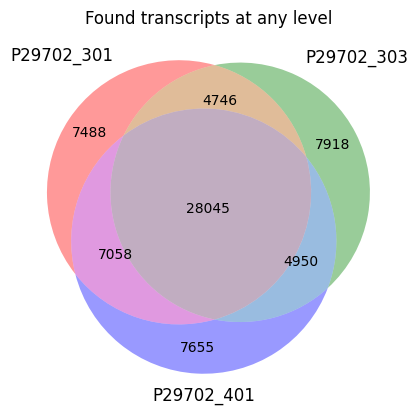

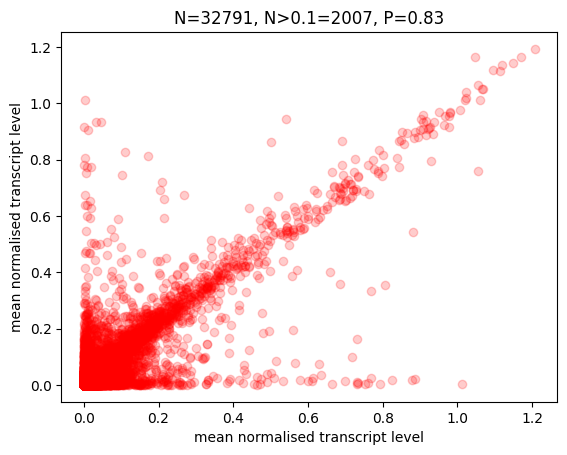

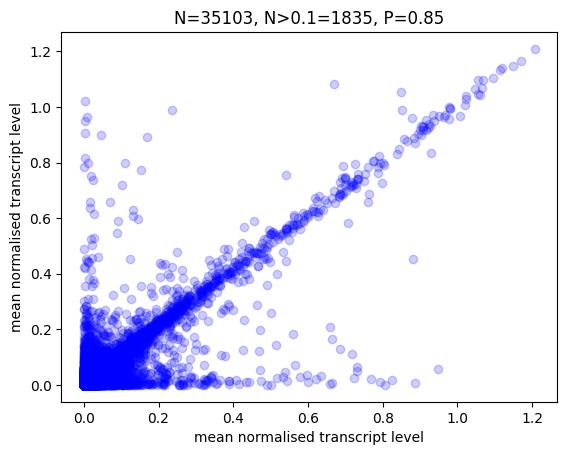

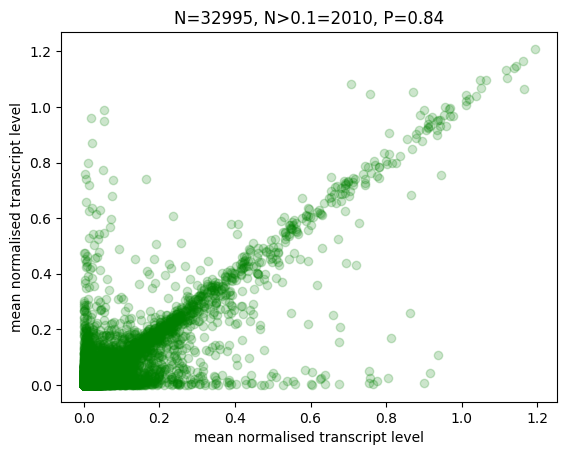

In [4]:
# get mean expression per transcript in each dataset
expression_301 = adata_301.X
expression_301 = np.mean(expression_301, axis=0)
# Add gene names to the expression matrix
expression_301 = pd.DataFrame(expression_301, index=adata_301.var_names)

expression_303 = adata_303.X
expression_303 = np.mean(expression_303, axis=0)
# Add gene names to the expression matrix
expression_303 = pd.DataFrame(expression_303, index=adata_303.var_names)

expression_401 = adata_401.X
expression_401 = np.mean(expression_401, axis=0)
# Add gene names to the expression matrix
expression_401 = pd.DataFrame(expression_401, index=adata_401.var_names)

# merge the expression matrices
expression = pd.concat([expression_301, expression_303, expression_401], axis=1)
# remove genes that are not in all datasets
expression_301_303 = expression.iloc[:,[0,1]].dropna()
expression_301_401 = expression.iloc[:,[0,2]].dropna()
expression_303_401 = expression.iloc[:,[1,2]].dropna()
expression = expression.dropna()


# make venn diagram of expression. Intersection is non-na transcripts
from matplotlib_venn import venn3, venn3_circles
venn3([set(expression_301.index), set(expression_303.index), set(expression_401.index)], set_labels=tpr_names)
plt.title("Found transcripts at any level")
plt.show()

# scatter plot 301 vs 303
pearson_301_303 = expression_301_303.iloc[:,0].corr(expression_301_303.iloc[:,1])
non_zero_301_303 = len(expression_301_303[(expression_301_303.iloc[:,0] > 0.1) | (expression_301_303.iloc[:,1] > 0.1)])
plt.scatter(expression_301_303.iloc[:,0], expression_301_303.iloc[:,1], alpha=0.2, c='red')
plt.title(f"N={len(expression_301_303)}, N>0.1={non_zero_301_303}, P={pearson_301_303.round(2)}")
plt.xlabel("mean normalised transcript level")
plt.ylabel("mean normalised transcript level")
plt.show()

# scatter plot 301 vs 401
pearson_301_401 = expression_301_401.iloc[:,0].corr(expression_301_401.iloc[:,1])
non_zero_301_401 = len(expression_301_401[(expression_301_401.iloc[:,0] > 0.1) | (expression_301_401.iloc[:,1] > 0.1)])
plt.scatter(expression_301_401.iloc[:,0], expression_301_401.iloc[:,1], alpha=0.2, c='blue')
plt.title(f"N={len(expression_301_401)}, N>0.1={non_zero_301_401}, P={pearson_301_401.round(2)}")
plt.xlabel("mean normalised transcript level")
plt.ylabel("mean normalised transcript level")
plt.show()

# scatter plot 303 vs 401
pearson_303_401 = expression_303_401.iloc[:,0].corr(expression_303_401.iloc[:,1])
non_zero_303_401 = len(expression_303_401[(expression_303_401.iloc[:,0] > 0.1) | (expression_303_401.iloc[:,1] > 0.1)])
plt.scatter(expression_303_401.iloc[:,0], expression_303_401.iloc[:,1], alpha=0.2, c='green')
plt.title(f"N={len(expression_303_401)}, N>0.1={non_zero_303_401}, P={pearson_303_401.round(2)}")
plt.xlabel("mean normalised transcript level")
plt.ylabel("mean normalised transcript level")
plt.show()


